In [1]:
from profiler.core import *

## 1. Instantiate Engine
* workers : number of processes
* tol     : tolerance for differences when creating training data (set to 0 if data is completely clean)
* eps     : error bound for inverse covariance estimation (since we use conservative calculation when determining minimum sample size, we recommend to set eps <= 0.01)
* embedtxt: if set to true, differentiate b/w textual data and categorical data, and use word embedding for the former

In [2]:
pf = Profiler(workers=2, tol=0.01, eps=0.05, embedtxt=False)

## 2. Load Data
* name: any name you like
* src: \[FILE; DF; DB (not implemented)\]
* fpath: required if src == FILE
* df: required if src == DF
* check_param: print parameters used for data loading

In [3]:
pf.session.load_data(name='hospital', src=FILE, fpath='data/TECHospital.csv', encoding="latin-1",
                     check_param=True, na_values='not available')

INFO:profiler.utility:[0.006948947906494141] Load Data start

INFO:profiler.dataset:parameters used for data loading:
 {'na_values': 'not available', 'sep': ',', 'header': 'infer', 'dropcol': None, 'dropna': False, 'encoding': 'latin-1', 'normalize': True, 'min_categories_for_embedding': 10}
INFO:profiler.dataset:inferred types of attributes: {
    "Provider ID": "numeric",
    "Hospital Name": "text",
    "Address": "text",
    "City": "text",
    "State": "text",
    "ZIP Code": "numeric",
    "County Name": "text",
    "Phone Number": "numeric",
    "Condition": "categorical",
    "Measure ID": "text",
    "Measure Name": "text",
    "Score": "text",
    "Sample": "text",
    "Footnote": "text",
    "Measure Start Date": "categorical",
    "Measure End Date": "categorical"
}
INFO:profiler.dataset:(possible types: numeric, categorical, text, date)
INFO:profiler.dataset:inferred operators of attributes: {'Provider ID': ['equal'], 'Hospital Name': ['equal'], 'Address': ['equal'], 'City

### 2.1 Change Data Types of Attributes
* required input:
    * a list of attributes
    * a list of data types (must match the order of the attributes; can be CATEGORICAL, NUMERIC, TEXT, DATE)
* optional input:
    * a list of regular expression extractor

In [4]:
pf.session.change_dtypes(['Provider ID', 'Phone Number', 'Score', 'Sample', 'Measure Start Date', 'Measure End Date'], 
                            [CATEGORICAL, CATEGORICAL, NUMERIC, NUMERIC, DATE, DATE])

INFO:profiler.dataset:updated types of Provider ID to 'categorical'
INFO:profiler.dataset:updated operators of Provider ID to ['equal']
INFO:profiler.dataset:updated types of Phone Number to 'categorical'
INFO:profiler.dataset:updated operators of Phone Number to ['equal']
INFO:profiler.dataset:updated types of Score to 'numeric'
INFO:profiler.dataset:updated operators of Score to ['equal']
INFO:profiler.dataset:updated types of Sample to 'numeric'
INFO:profiler.dataset:updated operators of Sample to ['equal']
INFO:profiler.dataset:updated operators of Measure Start Date to ['equal']
INFO:profiler.dataset:updated operators of Measure End Date to ['equal']
INFO:profiler.dataset:updated inferred operators of attributes: {'Provider ID': ['equal'], 'Hospital Name': ['equal'], 'Address': ['equal'], 'City': ['equal'], 'State': ['equal'], 'ZIP Code': ['equal'], 'County Name': ['equal'], 'Phone Number': ['equal'], 'Condition': ['equal'], 'Measure ID': ['equal'], 'Measure Name': ['equal'], 'Sco

### 2.2. Load/Train Embeddings for TEXT
* path: path to saved/to-save embedding folder
* load: set to true -- load saved vec from 'path'; set to false -- train locally
* save: (only for load = False) save trained vectors to 'path'

## 3. Load Training Data
* multiplier: if set to None, will infer the minimal sample size; otherwise, it will create (# samples) * (# attributes) * (multiplier) training samples

In [5]:
pf.session.load_training_data(multiplier = None)

INFO:profiler.utility:[17.964517831802368] Create Training Data start

INFO:profiler.transformer:needs multiplier = 2 to bound the error in inv cov estimation <= 0.05000000
INFO:profiler.transformer:use multiplier = 2, and the bound is 0.00005616
INFO:profiler.transformer:Draw Pairs
100%|██████████| 16/16 [00:02<00:00,  7.16it/s]
INFO:profiler.transformer:Number of training samples: 1614816
INFO:profiler.transformer:Computing Differences
INFO:profiler.transformer:estimated missing data probability in training data is 0.0855
INFO:profiler.utility:[29.069162130355835] Create Training Data execution time: 11.104644298553467



## 4. Learn Structure
* sparsity: intensity of L1-regularizer in inverse covariance estimation (glasso)
* take_neg: if set to true, consider equal -> equal only

In [6]:
autoregress_matrix = pf.session.learn_structure(sparsity=0.1, infer_order=False)

INFO:profiler.utility:[29.07545304298401] Learn Structure start

INFO:profiler.learner:use threshold 0.0392
INFO:profiler.utility:[29.538742065429688] Learn Structure execution time: 0.4632890224456787



* score: 
    * "fit_error": mse for fitting y = B'X + c for each atttribute y 
    * "training_data_fd_vio_ratio": the higher the score, the more violations of FDs in the training data. (bounded: \[0,1\])

In [7]:
parent_sets = pf.session.get_dependencies(score="fit_error")

INFO:profiler.utility:[29.54626703262329] Get Dependencies start



Provider ID -> Hospital Name (0.022575206575587467)
Provider ID,Hospital Name -> Address (0.007858245187263354)
Provider ID,Hospital Name,Address -> City (0.01860290496449381)
Provider ID,Hospital Name,Address,City -> State (0.07425846555898286)
Provider ID,Hospital Name,Address,City,State -> ZIP Code (0.028439457864752386)
Provider ID,Hospital Name,Address,City,State,ZIP Code -> County Name (0.018090274389216256)
Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name -> Phone Number (0.0029760214091091026)
Measure ID -> Measure Name (0.04483222410072152)


INFO:profiler.utility:[30.134317874908447] Get Dependencies execution time: 0.5880508422851562



Measure ID,Measure Name -> Condition (0.23229817014052462)
Measure Start Date -> Measure End Date (0.07768434250278881)


## 5. Visualization

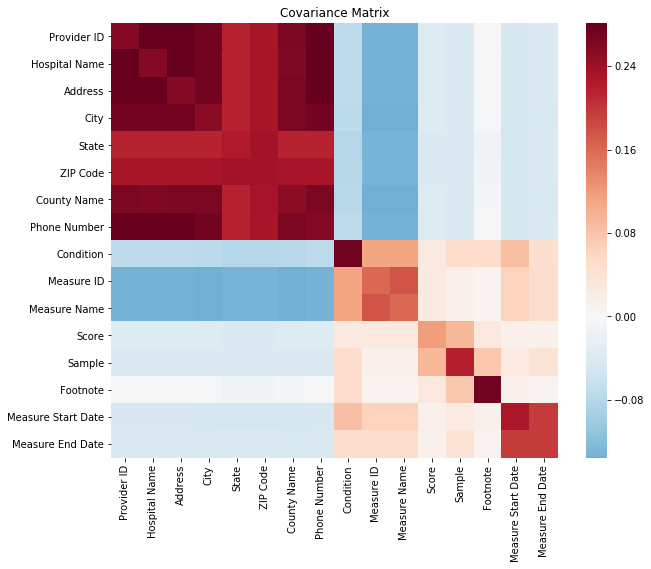

In [12]:
pf.session.visualize_covariance()

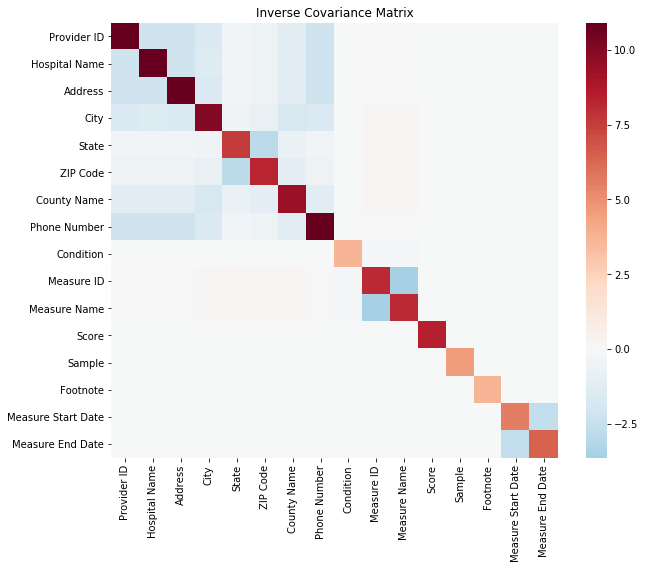

In [9]:
pf.session.visualize_inverse_covariance()

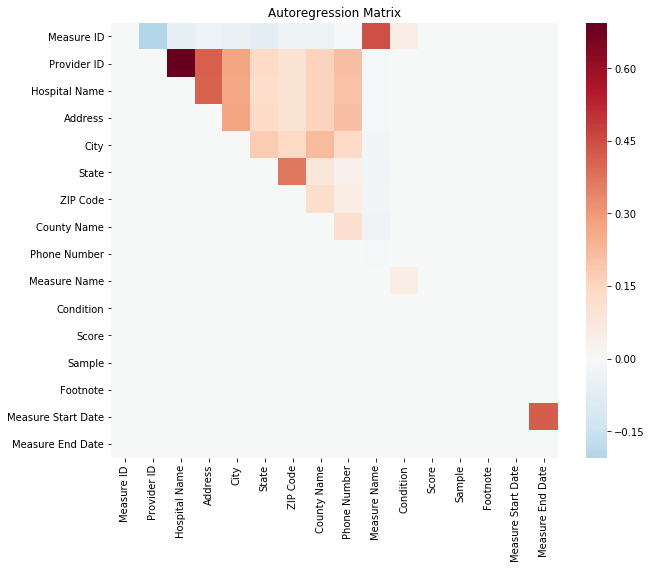

In [10]:
pf.session.visualize_autoregression()

In [11]:
pf.session.timer.get_stat()

,time_point,msg,execution_time
0,0.006949,start: Load Data,0.000000
1,1.052103,end: Load Data,1.045154
2,17.964518,start: Create Training Data,0.000000
3,29.069162,end: Create Training Data,11.104644
4,29.075453,start: Learn Structure,0.000000
5,29.538742,end: Learn Structure,0.463289
6,29.546267,start: Get Dependencies,0.000000
7,30.134318,end: Get Dependencies,0.588051
8,30.134318,total_execution_time,13.201138
